In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import math
import collections as clt

In [2]:
plt.rcParams["figure.figsize"] = (10,7) #defining size of plots

In [3]:
df = pd.read_csv('all_reviews.csv')

In [4]:
df.shape

(93434, 6)

In [5]:
df.columns

Index(['Year', 'Date', 'User', 'Release', 'Score', 'Band'], dtype='object')

In [6]:
df

,Year,Date,User,Release,Score,Band
0,2002,2002.07.11.06:45,8U,517380A,82,21B
1,2002,2002.07.14.09:19,8U,46A,88,14B
2,2002,2002.07.15.00:23,20U,133A,90,39B
3,2002,2002.07.16.03:43,21U,2A,87,4B
4,2002,2002.07.16.22:38,14U,21A,70,3B
...,...,...,...,...,...,...
93429,2017,2017.06.30.16:24,112373U,133802A,85,5123B
93430,2017,2017.06.30.16:30,112373U,270894A,65,327B
93431,2017,2017.06.30.16:41,112373U,45363A,80,5123B
93432,2017,2017.06.30.22:21,76229U,140056A,89,9208B


In [7]:
df.describe()

,Year,Score
count,93434.000000,93434.000000
mean,2010.178661,77.220905
std,3.782777,20.475495
min,2002.000000,0.000000
25%,2007.000000,70.000000
50%,2010.000000,83.000000
75%,2013.000000,90.000000
max,2017.000000,100.000000


In [8]:
np.median([i for i in clt.Counter(df['User']).values()])

2.0

In [9]:
clt.Counter(clt.Counter(df['User']).values())[2]

1461

In [10]:
users = set(df['User'])

In [11]:
len(users)

9318

In [12]:
#posScore = df['Score'].quantile(.5)
posScore = 75

In [13]:
np.mean(df['Score'])

77.22090459575743

In [14]:
print("Positive Score Threshold =",posScore)

Positive Score Threshold = 75


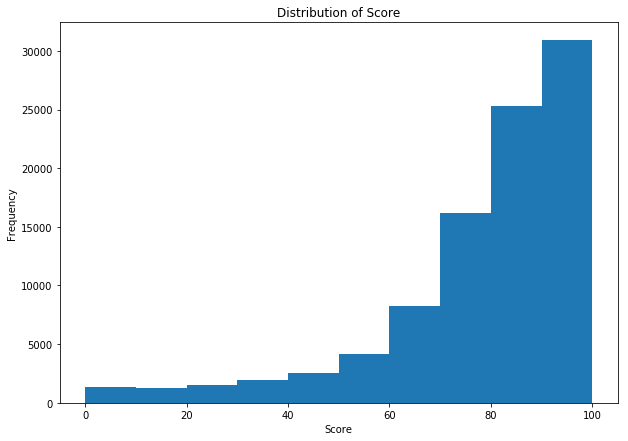

In [15]:
plt.title('Distribution of Score')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.hist(df['Score'])
plt.savefig("Distribution of Score.png")

In [16]:
G = nx.Graph() #network of users
B = nx.Graph() #bipartite graph between users and releases
G.add_nodes_from(users)
B.add_nodes_from(users)

In [17]:
#construction of bipartite graph between users and releases
bandmp = {}
for i in range(len(df)):
    if df['Score'][i] >= posScore:#positive review is defined as score >= 75
    #if df['Score'][i] == 100:#only consider positive review as full score of 100
        B.add_edge(df['Release'][i], df['User'][i])
        B[df['Release'][i]][df['User'][i]]['year'] = df['Year'][i]
        #users.add(df['User'][i]) #removing isolated nodes
    #connect release to band, assuming each release only has one band
    #if df['Release'][i] in band and band[df['Release'][i]] != df['Band'][i]:
        #print("Error at index",i)
    bandmp[df['Release'][i]] = df['Band'][i]

In [18]:
#constructing edges, and counting the frequency (i.e. number of repeated edges)
edges = {}
releases = {}
findYear = {}
for user in users:
    for release in B.adj[user]:
        for node in B.adj[release]:
            if node != user:
                if (user, node) in edges:
                    edges[(user, node)] += 1
                    releases[(user, node)].append(release)
                    findYear[(user, node)].append(max(B[node][release]['year'],B[user][release]['year']))
                elif (node, user) in edges:
                    edges[(node, user)] += 1
                    releases[(node, user)].append(release)
                    findYear[(node, user)].append(max(B[node][release]['year'],B[user][release]['year']))
                else:
                    edges[(user, node)] = 1
                    releases[(user, node)] = []
                    releases[(user, node)].append(release)
                    findYear[(user, node)] = []
                    findYear[(user, node)].append(max(B[node][release]['year'],B[user][release]['year']))

In [19]:
for edge in edges:
    G.add_edge(edge[0], edge[1], weight = edges[edge]/2)#because double counted
    #add individual releases to each edge
    G[edge[0]][edge[1]]['releases'] = set(releases[edge])
    tmp = clt.Counter(findYear[edge])
    findYear_final = {}
    for item in tmp:
        findYear_final[item] = int(tmp[item]/2)
    G[edge[0]][edge[1]]['year'] = findYear_final

In [20]:
#calculating similarity between two nodes which share an edge (else default is zero).
#By using each edge, this method cuts down time complexity from O(N^2) to O(E)
def calc_sim(Graph):
    for u,v in Graph.edges():
        #similarity = 2*overlap/sum of degrees of u and v
        sum_of_degrees = Graph.degree(u,weight = 'weight')+Graph.degree(v,weight = 'weight')
        common_edges = Graph[u][v]['weight']
        Graph[u][v]['similarity'] = (2*common_edges)/sum_of_degrees #is this the best way?
        #G[u][v]['similarity'] = common_edges/(sum_of_degrees - common_edges)
    return Graph

In [21]:
G = calc_sim(G)

In [22]:
#Assigning weights based on frequency
weights = [G[u][v]['weight'] for u,v in G.edges()]
sim_score = [G[u][v]['similarity'] for u,v in G.edges()]
#print(weights)

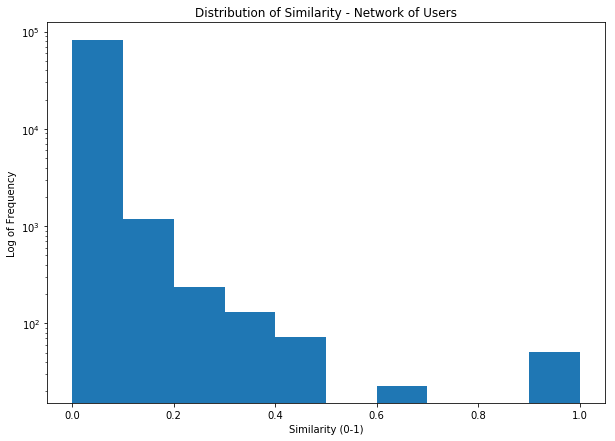

In [23]:
plt.title('Distribution of Similarity - Network of Users')
plt.xlabel('Similarity (0-1)')
plt.ylabel('Log of Frequency')
#print(min(sim_score))
plt.hist(sim_score, log = True)#specify the number of bins -> 
plt.savefig("Distribution of Similarity - Network of Users.png")

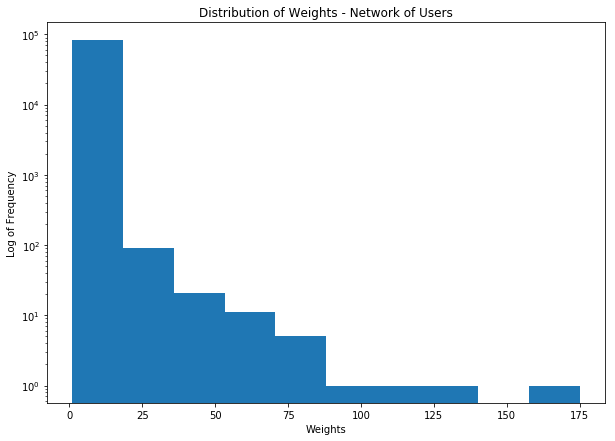

In [24]:
plt.title('Distribution of Weights - Network of Users')
plt.xlabel('Weights')
plt.ylabel('Log of Frequency')
plt.hist(weights, log = True)
plt.savefig("Distribution of Weights - Network of Users.png")

In [25]:
print("Maximum Weight (i.e. Frequency) =",max(weights))
print("Number of edges =",len(weights))
print("Number of nodes =",len(G.nodes()))

Maximum Weight (i.e. Frequency) = 175.0
Number of edges = 84373
Number of nodes = 9318


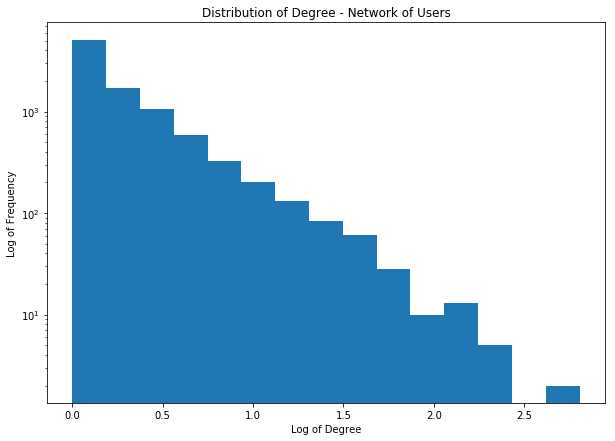

In [26]:
plt.title('Distribution of Degree - Network of Users')
plt.xlabel('Log of Degree')
plt.ylabel('Log of Frequency')
data = np.log10([b+10 for a,b in G.degree(list(G.nodes()), weight = 'weight')])-1 #+10 to account for 0 case
#_,bins = np.histogram(data + 1, bins='auto')
#data = [b for a,b in G.degree(list(G.nodes()))]
#plt.gca().set_xscale('log')
plt.hist(data, log = True, bins = 15)
plt.savefig("Distribution of Degree - Network of Users.png")
#print([b for a,b in G.degree(list(G.nodes()))])
#Hopefully able to observe Power Law Distribution

In [27]:
#Only run this when size is small
#nx.draw(G, node_size = 10, width = weights)
#plt.show()

In [28]:
clt.Counter(sorted([len(cc) for cc in nx.connected_components(G)]))

Counter({1: 2406, 2: 51, 3: 4, 4: 1, 6794: 1})

In [29]:
#Splitting the graph into connected subgraphs
'''
graphs = list(nx.connected_components(G))

for subgraph in graphs:
    if len(subgraph) < 3:#only consider subgraphs with size > 3
        continue
    graph = G.subgraph(subgraph)
    weights1 = [graph[u][v]['weight'] for u,v in graph.edges()]
    nx.draw(graph, node_size = 10, width = weights1)
    plt.show()
'''

"\ngraphs = list(nx.connected_components(G))\n\nfor subgraph in graphs:\n    if len(subgraph) < 3:#only consider subgraphs with size > 3\n        continue\n    graph = G.subgraph(subgraph)\n    weights1 = [graph[u][v]['weight'] for u,v in graph.edges()]\n    nx.draw(graph, node_size = 10, width = weights1)\n    plt.show()\n"

In [30]:
'''H = nx.Graph() #network of releases'''

'H = nx.Graph() #network of releases'

In [31]:
'''#constructing edges, and counting the frequency (i.e. number of repeated edges)
edgesNew = {}
for release in mp:
    for item in B.adj[release]:
        for node in B.adj[item]:
            if node != release:
                if (release, node) in edgesNew:
                    edgesNew[(release, node)] += 1
                elif (node, release) in edgesNew:
                    edgesNew[(node, release)] += 1
                else:
                    edgesNew[(release, node)] = 1

for edge in edgesNew:
    H.add_edge(edge[0], edge[1], weight = edgesNew[edge]/2)#double counted

#Assigning weights based on frequency
weightsNew = [H[u][v]['weight'] for u,v in H.edges()]'''

"#constructing edges, and counting the frequency (i.e. number of repeated edges)\nedgesNew = {}\nfor release in mp:\n    for item in B.adj[release]:\n        for node in B.adj[item]:\n            if node != release:\n                if (release, node) in edgesNew:\n                    edgesNew[(release, node)] += 1\n                elif (node, release) in edgesNew:\n                    edgesNew[(node, release)] += 1\n                else:\n                    edgesNew[(release, node)] = 1\n\nfor edge in edgesNew:\n    H.add_edge(edge[0], edge[1], weight = edgesNew[edge]/2)#double counted\n\n#Assigning weights based on frequency\nweightsNew = [H[u][v]['weight'] for u,v in H.edges()]"

In [32]:
#Only run this when size is small
#nx.draw(H, node_size = 10, width = weightsNew)
#plt.show()

In [33]:
#GC = nx.Graph(G.subgraph(list(nx.connected_components(G))[0]))#giant component of network of users, nx.Graph is to unfreeze graph

In [34]:
mp = clt.Counter(df['User'])
remove_users = [user for user in users if mp[user] < 3]

In [35]:
len(G.nodes()),len(remove_users)

(9318, 5569)

In [36]:
G1 = nx.Graph(G) #Copy of graph G

In [37]:
G1.remove_nodes_from(remove_users)
tmp = list(nx.isolates(G1))
print(len(tmp))
G1.remove_nodes_from(tmp)

237


In [38]:
nx.number_connected_components(G1)

1

In [39]:
clt.Counter(sorted([len(cc) for cc in nx.connected_components(G1)]))

Counter({3512: 1})

In [40]:
GC = G1 #G1 is just one giant component

In [41]:
len(GC.nodes())

3512

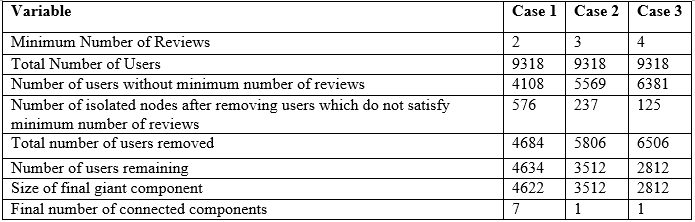

In [42]:
#This portion takes into account only Giant Component
#binning node degrees by log factor (i.e. each bin has the range  [a^x,a^(x+1)))
powers = []
for node in GC.nodes():
    powers.append(1.1**math.floor(math.log(GC.degree(node,weight = 'weight'),1.1)))

degree_x = []
degree_y = []
d_freq = clt.Counter(powers)
for item in d_freq:
    degree_x.append(math.log10(math.sqrt(item*(item*1.1))))
    degree_y.append(math.log10(d_freq[item]))
#finding best fit line
m,c = np.polyfit(degree_x,degree_y,1)#polynomial degree 1 (i.e. linear)
print(m,c)

-0.7304891841677603 2.8222644911163477


In [43]:
y_pred = [m*x + c for x in degree_x]
MSE = np.square(np.subtract(degree_y,y_pred)).mean()
print("Mean Squared Error =", MSE)

Mean Squared Error = 0.06480437383361766


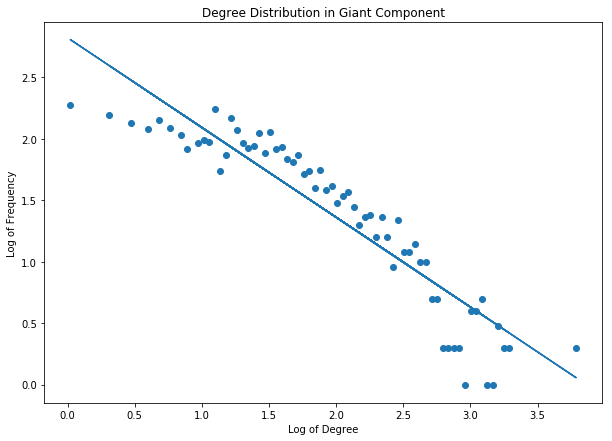

In [44]:
plt.title('Degree Distribution in Giant Component')
plt.xlabel('Log of Degree')
plt.ylabel('Log of Frequency')
plt.scatter(degree_x,degree_y)
plt.plot(degree_x,m*np.array(degree_x)+c)
plt.savefig('Degree Distribution in Giant Component')

In [45]:
#Power Law Window
#binning node degrees by log factor (i.e. each bin has the range  [a^x,a^(x+1)))
powers = []
for node in GC.nodes():
    powers.append(1.1**math.floor(math.log(GC.degree(node,weight = 'weight'),1.1)))

degree_x = []
degree_y = []
d_freq = clt.Counter(powers)
for item in d_freq:
    x = math.log10(math.sqrt(item*(item*1.1)))
    if x > 1 and x < 2.5:
        degree_x.append(x)
        degree_y.append(math.log10(d_freq[item]))
#finding best fit line
m,c = np.polyfit(degree_x,degree_y,1)#polynomial degree 1 (i.e. linear)
print(m,c)

-0.6414201619969255 2.8195427961672155


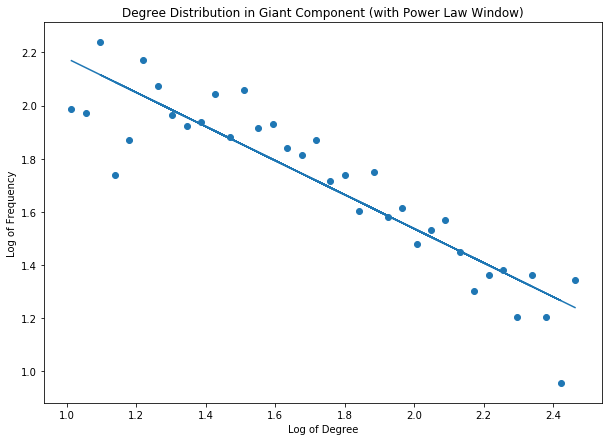

In [46]:
plt.title('Degree Distribution in Giant Component (with Power Law Window)')
plt.xlabel('Log of Degree')
plt.ylabel('Log of Frequency')
plt.scatter(degree_x,degree_y)
plt.plot(degree_x,m*np.array(degree_x)+c)
plt.savefig('Degree Distribution in Giant Component (with Power Law Window)')

In [47]:
y_pred = [m*x + c for x in degree_x]
MSE = np.square(np.subtract(degree_y,y_pred)).mean()
print("Mean Squared Error =", MSE)

Mean Squared Error = 0.01601109016603476


In [48]:
def cluster(sim):
    #this function generates a graph which is a collection of subgraphs from the original graph
    #after removing all edges with similarity < sim, where sim is to be determined
    #to generate full graph, used for point query
    GC_split = nx.Graph()
    GC_split.add_nodes_from(GC.nodes())
    for u,v in GC.edges():
        if GC[u][v]['similarity'] >= sim:
            GC_split.add_edge(u,v)
            GC_split[u][v]['weight'] = GC[u][v]['weight']
            GC_split[u][v]['similarity'] = GC[u][v]['similarity']
            GC_split[u][v]['releases'] = GC[u][v]['releases']
            GC_split[u][v]['year'] = GC[u][v]['year']
    return GC_split

In [49]:
def cluster_fast(sim):
    #a faster version of cluster function, but without edge attributes, for computational purposes only
    GC_split = nx.Graph()
    GC_split.add_nodes_from(GC.nodes())
    for u,v in GC.edges():
        if GC[u][v]['similarity'] >= sim:
            GC_split.add_edge(u,v)
    return GC_split

In [50]:
def components(Graph):
    #returns a list connected components of a graph (a list of lists of nodes in each connected component)
    return list(nx.connected_components(Graph))

In [51]:
def getSize(Graph):
    #returns a list of the size of disconnected subgraphs in a graph
    return [len(x) for x in list(nx.connected_components(Graph))]

In [52]:
def entropy(sim, Graph = nx.Graph()):
    #can be used both for range and point query
    #calculates the Shannon Entropy of a graph
    #if input is a graph instead of similarity value, set sim = -1
    sum = 0
    if sim == -1:#used by range function entropy_range
        clusters = components(Graph)
    else:#used individually
        clusters = components(cluster_fast(sim))
    N = len(GC.nodes())
    for comp in clusters:
        P = len(comp)/N #P is the probability of a node being in a particular component/cluster
        sum += -1*P*math.log10(P)
    return sum

In [53]:
def entropy_range(sim_x, isShannon = False):
    #runs in linear time, but needs to be initialised from largest to smallest similarity
    #takes in a range of values and adds edges individually from greatest to smallest similarity
    #used for range query
    #isShannon is a boolean which is True when finding Shannon Entropy and False when finding Cluster Entropy
    #can be used for both types of entropy by specifying boolean
    #range query reduces run time as graph is only constructed once
    #returns list of entropy values
    pos = 0
    GC_split = nx.Graph()
    GC_split.add_nodes_from(GC.nodes())
    edges = []
    for u,v in GC.edges():
        edges.append((GC[u][v]['similarity'],u,v))
    edges.sort(reverse = True)
    ret = []
    for sim in sim_x:
        for i in range(pos,len(edges)):
            edgesim, u, v = edges[i]
            if edgesim >= sim:
                GC_split.add_edge(u,v)
            else:
                break
        pos = i
        if isShannon:
            ret.append(entropy(-1,GC_split))
        else:
            ret.append(clusterentropy(-1,GC_split))
    ret.reverse()
    return ret

In [54]:
def clusterentropy(sim, Graph = nx.Graph()):
    #can be used both for range and point query
    #set sim = -1 if input is a graph
    if sim == -1:#used by range function entropy_range
        freq = clt.Counter(getSize(Graph))
    else:#used individually
        freq = clt.Counter(getSize(cluster_fast(sim)))
    sum = 0
    N = len(GC.nodes())
    for item in freq:
        P = item*freq[item]/N
        sum += -1*P*math.log10(P) # P is the probability of a cluster having a particular size X (X = item in this case)
    return sum

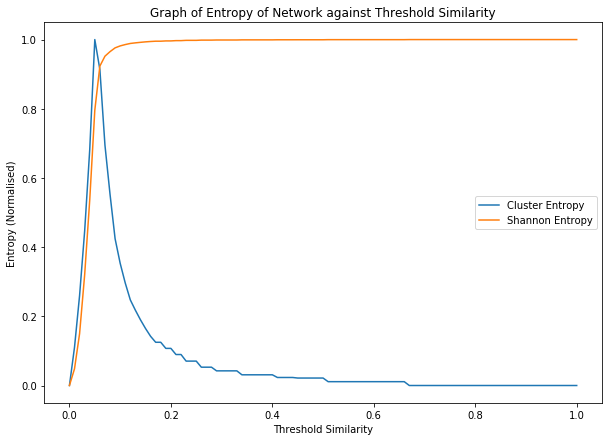

In [55]:
sim_x = [0.01*x for x in range(101)] 
sim_y = entropy_range(reversed(sim_x), True)
max_y = max(sim_y)
sim_y = [item/max_y for item in sim_y]
sim_y1 = entropy_range(reversed(sim_x))
max_y1 = max(sim_y1)
sim_y1 = [item/max_y1 for item in sim_y1]
#print(sim_y)
#sim_x = 0.04*np.array(range(0,26))
plt.title('Graph of Entropy of Network against Threshold Similarity')
plt.xlabel('Threshold Similarity')
plt.ylabel('Entropy (Normalised)')
plt.plot(sim_x,sim_y1, label = 'Cluster Entropy')
plt.plot(sim_x,sim_y, label = 'Shannon Entropy')
plt.legend()
plt.savefig('Graph of Entropy of Network against Threshold Similarity')

In [56]:
def entropy_rangemax(sim_x):
    #runs in linear time, but needs to be initialised from largest to smallest similarity
    #takes in a range of values and adds edges individually from greatest to smallest similarity
    #used for range query
    #Different from entropy_range
    #This returns the maximum entropy and the similarity value at which cluster entropy is maximum
    pos = 0
    GC_split = nx.Graph()
    GC_split.add_nodes_from(GC.nodes())
    edges = []
    for u,v in GC.edges():
        edges.append((GC[u][v]['similarity'],u,v))
    edges.sort(reverse = True)
    bestsim = -1
    maxi = -1
    for i1, sim in enumerate(sim_x):
        for i in range(pos,len(edges)):
            edgesim, u, v = edges[i]
            if edgesim >= sim:
                GC_split.add_edge(u,v)
            else:
                break
        pos = i
        x = clusterentropy(-1,GC_split)
        if x > maxi:
            maxi = x
            bestsim = sim
    return maxi,bestsim

In [57]:
#Based on graph, calculate similarity that gives maximum certainty

#Searches with precision of 0.01 in entire range of similarity from 0-1
sim_x = [0.01*x for x in range(101)]#reversed
maxi, sim = entropy_rangemax(reversed(sim_x))
print("Maximum Cluster Entropy:",maxi," when Similarity =",sim)

#Searches with precision of 0.001 within new range based on previous search
sim_x = [0.001*x + sim for x in range(-10,10)]
maxi, sim = entropy_rangemax(reversed(sim_x))
print("Maximum Cluster Entropy:",maxi," when Similarity =",sim)

#Searches with precision of 0.0001 within new range based on previous search (if needed)
sim_x = [0.0001*x + sim for x in range(-10,10)]
maxi, sim = entropy_rangemax(reversed(sim_x))
print("Maximum Cluster Entropy:",maxi," when Similarity =",sim)

#Searches with precision of 0.00001 within new range based on previous search (if needed)
sim_x = [0.00001*x + sim for x in range(-10,10)]
maxi, sim = entropy_rangemax(reversed(sim_x))
print("Maximum Cluster Entropy:",maxi," when Similarity =",sim)
#Therefore, optimal similarity value is determined to be 0.0593
optsim = sim #this value is determined for when posScore = 75
#when posScore = 83 at 50th percentile, optsim = 0.67
print(optsim,maxi)

Maximum Cluster Entropy: 0.7655665324595505  when Similarity = 0.05
Maximum Cluster Entropy: 0.7988489710971647  when Similarity = 0.055
Maximum Cluster Entropy: 0.8011883145094734  when Similarity = 0.0545
Maximum Cluster Entropy: 0.8011883145094734  when Similarity = 0.05454
0.05454 0.8011883145094734


In [58]:
DG = cluster(optsim)#disjointed graph (i.e. after removing edges with similarity < optsim )
comp = components(DG)

In [59]:
len(comp)

2317

In [60]:
#finding size of subgraphs in new graph generated with optsim
dist_size = []
tmp = clt.Counter(len(x) for x in comp)
for y in tmp:
    dist_size.append((y,tmp[y]))
dist_size = sorted(dist_size)
print(dist_size)

[(1, 1977), (2, 173), (3, 63), (4, 35), (5, 16), (6, 12), (7, 14), (8, 5), (9, 1), (10, 3), (11, 3), (12, 2), (13, 3), (15, 1), (18, 1), (19, 1), (20, 1), (27, 1), (29, 1), (34, 1), (41, 1), (103, 1), (129, 1)]


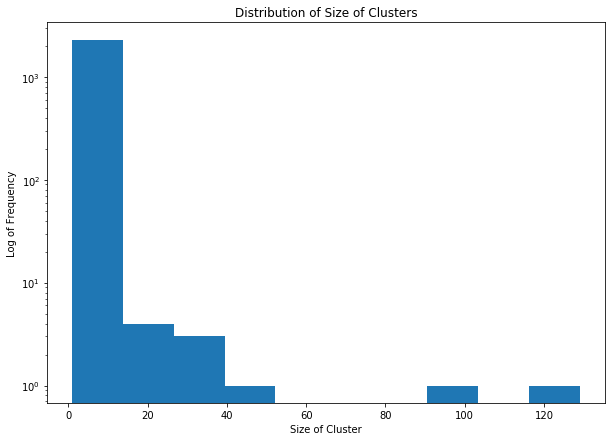

In [61]:
plt.title('Distribution of Size of Clusters')
plt.xlabel('Size of Cluster')
plt.ylabel('Log of Frequency')
plt.hist([len(x) for x in comp], log = True)
plt.savefig('Distribution of Size of Clusters')

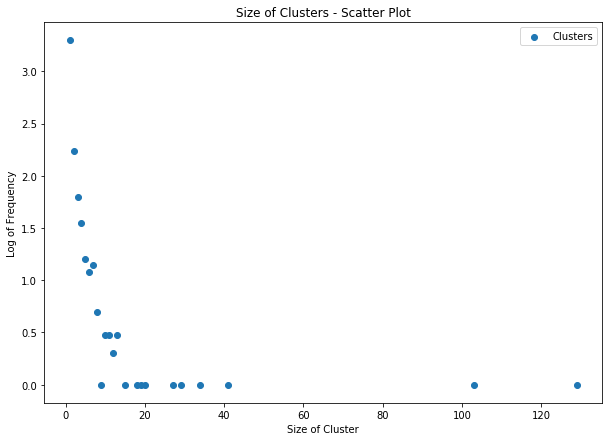

In [62]:
plt.title('Size of Clusters - Scatter Plot')
plt.xlabel('Size of Cluster')
plt.ylabel('Log of Frequency')
plt.scatter([x[0] for x in dist_size], [math.log10(x[1]) for x in dist_size],label = 'Clusters')
plt.legend()
plt.savefig('Size of Clusters - Scatter Plot')

In [63]:
#finding number of distinct bands per cluster and investigating relationship between size of cluster and band
grps = []
bands = []
for grp in comp:
    NG = DG.subgraph(grp) #NG represents each new subgraph using optsim
    grps.append(NG)
    Bands = set()
    for u,v in NG.edges():
        for item in NG[u][v]['releases']:
            Bands.add(bandmp[item])
    bands.append((len(grp),len(Bands)))

In [64]:
bands_x = [x[0] for x in bands]
bands_y = [x[1] for x in bands]

In [65]:
m1,c1 = np.polyfit(bands_x, bands_y, 1)#polynomial degree 1 (i.e. linear)

In [66]:
m1,c1

(0.7506688712302823, -0.7075308915670151)

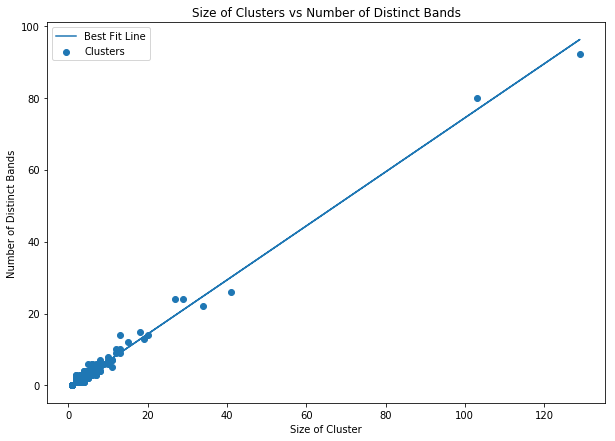

In [67]:
plt.title('Size of Clusters vs Number of Distinct Bands')
plt.xlabel('Size of Cluster')
plt.ylabel('Number of Distinct Bands')
plt.scatter(bands_x, bands_y,label = 'Clusters')
plt.plot(bands_x,m1*np.array(bands_x)+c1, label = 'Best Fit Line')
plt.legend()
plt.savefig('Size of Clusters vs Number of Distinct Bands')

In [68]:
y_pred = [m1*x + c1 for x in bands_x]
MSE = np.square(np.subtract(bands_y,y_pred)).mean()
print("Mean Squared Error =", MSE)

Mean Squared Error = 0.1073224065553933


In [69]:
#sorted descending list of all components (i.e. subgraphs) according to size
comps = [y[1] for y in sorted([(len(x),list(x)) for x in components(DG)], reverse = True)]

In [70]:
def filter_year(Graph, years):
    #returns graph with only edges from the list of years specified
    Y = nx.Graph()
    Y.add_nodes_from(Graph.nodes()) #this line can be added if isolated nodes are also displayed
    for u,v in Graph.edges():
        for year in years:
            if year in Graph[u][v]['year']:
                Y.add_edge(u,v)
                Y[u][v]['weight'] = Graph[u][v]['year'][year]
    return calc_sim(Y)

In [71]:
def get_subgraph(ind, years = [], calc = False):
    #if calc == False, returns subgraph with widths for network drawing
    #else returns the mean similairity and number of components
    SG = DG.subgraph(comps[ind])
    if len(years) != 0:
        SG = filter_year(SG, years)
    widths = np.array([SG[u][v]['similarity'] for u,v in SG.edges()])
    N = len(SG.nodes())
    #meanSim = np.sum(widths)/((N*(N-1))/2) #N*(N-1)/2 is total number of possible edges
    if len(widths) == 0:
        meanSim = np.nan #0 case
    else:
        meanSim = np.mean(widths)#mean similarity of edges
    no_of_comps = len(components(SG)) #does not include isolated nodes
    #total_comps = no_of_comps + len(comps[ind]) - len(SG.nodes()) #include isolated nodes in this computation
    if calc:
        #return (meanSim, no_of_comps, total_comps)
        return (meanSim, no_of_comps)
    else:
        print("Number of Nodes =",N)
        print("Mean Similarity = ",meanSim)
        print("Number of Connected Components =",no_of_comps)
        return SG,widths

In [72]:
def draw_subgraph(ind, years = [], label = False):
    #draws subgraph with index (ind) from the list of list of nodes comps
    #if years is not specified, entire graph is drawn
    SG, widths = get_subgraph(ind, years)
    nx.draw(SG, node_size = 15, width = 5*widths, pos = nx.spring_layout(SG), with_labels = label, font_size = 10) #node with = similarity
    #similarity*5 for visualisation purposes only
    plt.savefig('Subgraph ' + str(ind) + ' ' + str(years))

Number of Nodes = 129
Mean Similarity =  0.08719257907331342
Number of Connected Components = 1


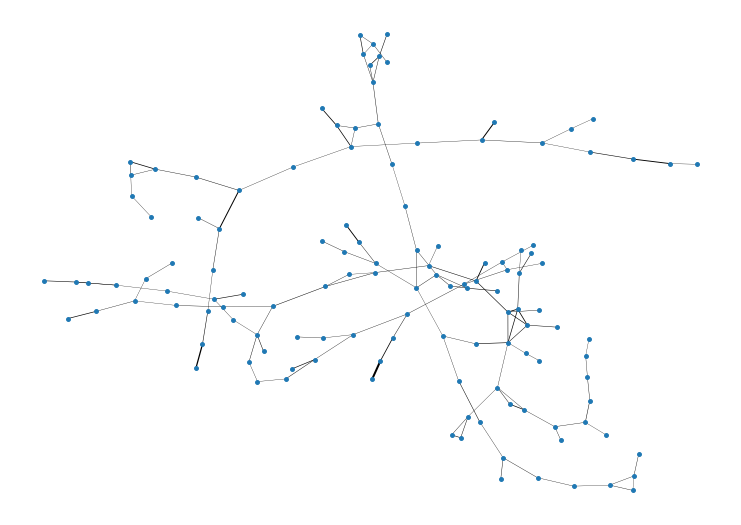

In [73]:
draw_subgraph(0) #largest subgraph

In [74]:
#draw_subgraph(0,range(2002,2008))

In [75]:
#draw_subgraph(0,range(2008,2013))

In [76]:
#draw_subgraph(0,range(2013,2018))

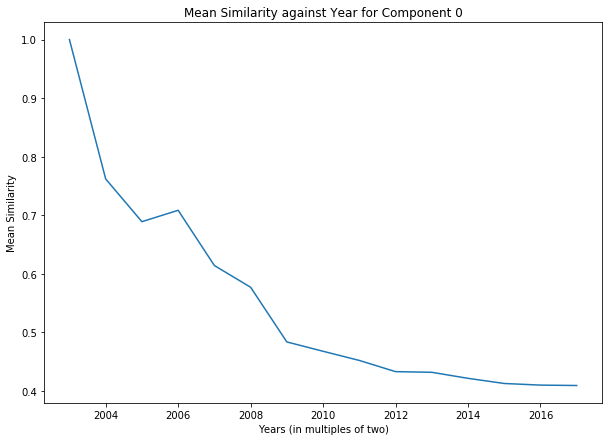

In [77]:
plt.title('Mean Similarity against Year for Component 0')#for every pair of nodes
plt.xlabel('Years (in multiples of two)')
plt.ylabel('Mean Similarity')#including nodes which do not share an edge
avesim_x = [x for x in range(2002,2018)] #each year
avesim_y = [get_subgraph(0,range(2002,x+1),True)[0] for x in avesim_x]
plt.plot(avesim_x,avesim_y)
plt.savefig('Mean Similarity against Year for Component 0')

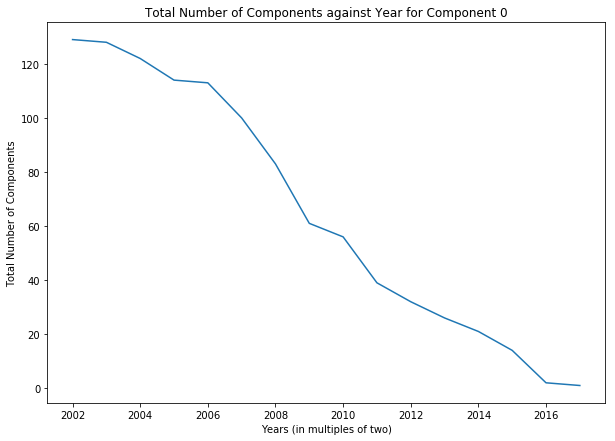

In [78]:
plt.title('Total Number of Components against Year for Component 0')
plt.xlabel('Years (in multiples of two)')
plt.ylabel('Total Number of Components')
avesim_x = [x for x in range(2002,2018)] #each year
avesim_y = [get_subgraph(0,range(2002,x+1),True)[1] for x in avesim_x]
plt.plot(avesim_x,avesim_y)
plt.savefig('Total Number of Components against Year for Component 0')

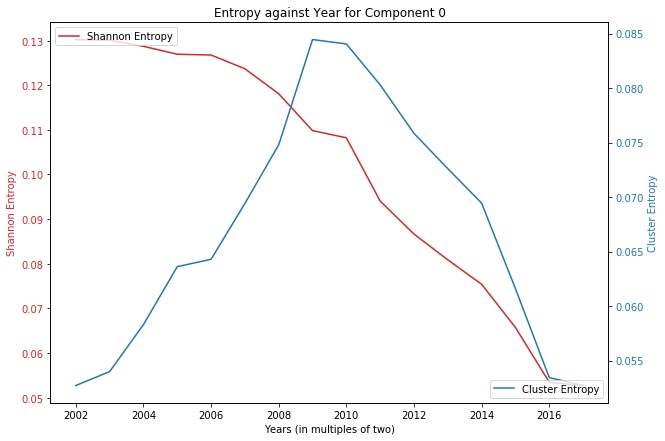

In [79]:
avesim_x = [x for x in range(2002,2018)] #each year
SG = DG.subgraph(comps[0])
ent_y = [entropy(-1,filter_year(SG,range(2002,x+1))) for x in avesim_x]
ent_y1 = [clusterentropy(-1,filter_year(SG,range(2002,x+1))) for x in avesim_x]
fig, ax1 = plt.subplots()
color1 = "tab:red"
color2 = "tab:blue"
ax1.set_title('Entropy against Year for Component 0')
ax1.set_xlabel('Years (in multiples of two)')
ax1.set_ylabel('Shannon Entropy', color = color1)
ax1.tick_params(axis='y', labelcolor = color1)
ax1.plot(avesim_x,ent_y, label = 'Shannon Entropy', color = color1)
ax2 = ax1.twinx()
ax2.set_ylabel('Cluster Entropy', color = color2)
ax2.tick_params(axis='y', labelcolor = color2)
ax2.plot(avesim_x,ent_y1, label = 'Cluster Entropy', color = color2)
ax1.legend(loc='upper left')
ax2.legend(loc='lower right')
plt.savefig('Entropy against Year for Component 0')

Number of Nodes = 129
Mean Similarity =  0.4834273182957393
Number of Connected Components = 61


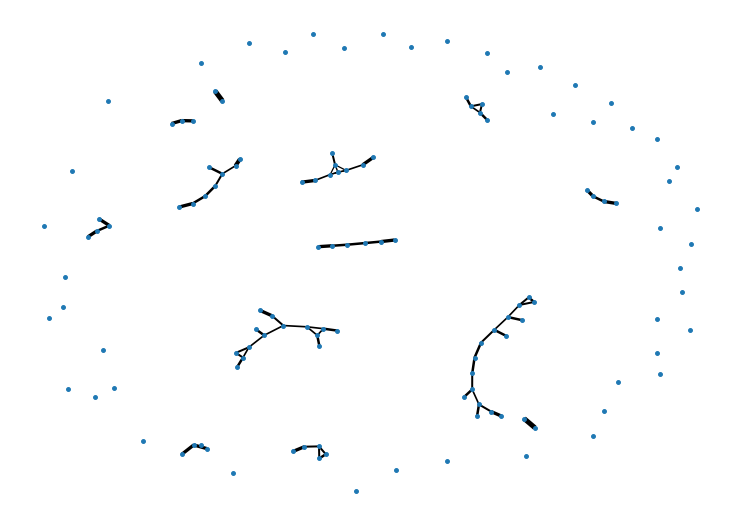

In [80]:
draw_subgraph(0,range(2002,2010))#where there is highest cluster entropy